# Criticality
This notebook contains experiments in determining how far away a network is from criticality. Also, what happens if you homeostatically regulate firing rates?

In [1]:
%matplotlib nbagg
import numpy as np
from scipy import optimize, stats, signal, sparse
import scipy.interpolate as interp
import networkx as nx

from braingeneers import drylab, analysis

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from functools import partial

In [2]:
# This is specific to my MPL configuration...
plt.style.use('arxiv')

In [3]:
def center_geom_bins(geom):
    "Given a geomspace, create a new one whose middles are this one's values."
    factor = np.sqrt(geom[1] / geom[0])
    return np.append(geom/factor, geom[-1]*factor)

In [4]:
def raster_plot(times, idces, N=None, tmin=None, tmax=None):
    
    N = N or np.max(idces)+1
    tmin = tmin or 0
    tmax = tmax or np.max(times)
    
    i = (times > tmin) & (times < tmax)
    times = times[i]
    idces = idces[i]
        
    ax = plt.figure().gca()
    ax.plot(times, idces + 1, '.', markersize=0.5)
    ax.set_xlim([tmin, tmax])
    ax.set_ylim([1, N])
    return ax

In [5]:
def empirical_pdf(ax, x, label=None, **kwargs):
    "A wrapper for pyplot histograms."
    n, bins, patches = ax.hist(x, label=label, density=True, 
                            histtype='step', **kwargs)
    
    # If we plotted multiple datasets in the same histogram 
    # call, patches is a list of lists, otherwise just a list.
    for poly_list in patches:
        try:
            poly_list[0]
        except TypeError:
            poly_list = [poly_list]
            
        for poly in poly_list:
            r, g, b, _ = poly.get_edgecolor()
            poly.set_facecolor((r,g,b,0.1))
            poly.set_fill(True)
    
    return n, bins, patches


In [6]:
def truncate_cdf(cdf, xmin=-np.inf, xmax=np.inf):
    def truncated(x, *a, **k):
        cmin = cdf(xmin, *a, **k)
        return (cdf(x, *a, **k) - cmin) / (cdf(xmax, *a, **k) - cmin)
    return truncated

In [7]:
def empirical_cdf(data):
    "Rearrange the points of data into an empirical CDF."
    return np.sort(data), np.linspace(0,1, len(data), endpoint=False)

def smooth_empirical_cdf(data):
    return interp.interp1d(*empirical_cdf(data),
                           fill_value=(0,1), bounds_error=False)


def cramer_vonmises(A, B, xmin=-np.inf, xmax=np.inf, **kwargs):
    """
    Compute the Cramér-von Mises criterion for distance between
    two distributions. If either is data, we generate an empirical
    CDF using smooth_empirical_cdf() first.
    """
    A = A if callable(A) else smooth_empirical_cdf(A)   
    B = B if callable(B) else smooth_empirical_cdf(B)
        
    return integrate.quad(lambda x: (A(x) - B(x))**2, 
                          xmin, xmax, **kwargs)


## Also simulating spikes

In [8]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 800

# Use a homogeneous population so things are clearer, differentiated
# only by type. 
a, b, c, d, C, k, Vr, Vt = np.array(N * [drylab.NEURON_TYPES['rs']]).T

# ms : time constant of synaptic current
tau = np.hstack((Ne*[5.0], (N-Ne)*[20.0]))

# mV : reversal potential of synapses
Vn = np.hstack((Ne*[0.0], (N-Ne)*[-70.0]))

# mV : spike peak voltage
Vp = 30

# Location of the bifurcation point in the RS single-cell dynamics.
vstar = 1/2 * (Vt + Vr + b/k)
ustar = b * (vstar - Vr)
Istar = k/4 * (Vt - Vr + b/k)**2

In [286]:
# Sij : fC total postsynaptic charge injected into
#       neuron i when neuron j fires. Song et al. (2005)
#       provide an empirical distribution for EPSPs,
#       but we convert those mV values into conductances 
#       that would produce the same effect in an RS cell
#       at rest. The conversion works out to 1nS/3mV.
mu, sigma = -0.702, 0.9355  
G = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))/3
# Inhibitory synapses should be stronger because there are 
# not as many of them. The factor is a little ambiguous though.
G[:,Ne:] *= 4
# Get rid of interinhibitory connections.
# G[Ne:,Ne:] = 0

# XY : μm planar positions of the cells.
XY = np.random.rand(2,N) * 75

# Generate random small-world connectivity using the
# XY defined right here, but with long-range inhibition
# prohibited.
beta = np.zeros((1,N))
beta[:Ne] = 5e-2
G *= analysis.small_world(XY / 12, plocal=0.5, beta=beta)

excitatory = np.arange(N) < Ne

In [287]:
# What is the probability that any given synapse is bidirectional?
def dirprobs(edges):
    bidir = edges & edges.T
    unidir = edges & ~bidir
    
    p_bidir = bidir.sum() / (N**2 - N)
    p_unidir = unidir.sum() / (N**2 - N)
    
    return p_bidir, p_unidir

p_bidir, p_unidir = dirprobs(G != 0)

print(f'We have {100*p_bidir:0.3f}% bidirectional',
      f'and {100*p_unidir:0.3f}% uni-directional probability.')
print(f'This is out of {100*(p_bidir + p_unidir):0.3f}% connection probability.')

We have 1.534% bidirectional and 1.872% uni-directional probability.
This is out of 3.406% connection probability.


In [288]:
# Transitivity is the probability that three nodes form a 
# triangle given that two of them are connected. In the
# Erdős-Renyi model, this is exactly equal to the connection  
# probability, so a higher value corresponds to increased 
# clustering in the graph.
Ggraph = nx.DiGraph(G)
p_transitive = nx.transitivity(Ggraph.to_undirected())
p_transitive_er = p_bidir + p_unidir
rel_trans = p_transitive / p_transitive_er
print(f'The synaptic connectivity graph is {rel_trans:0.1f} times more transitive than an ER graph.')

The synaptic connectivity graph is 11.7 times more transitive than an ER graph.


In [289]:
# Sample rate (kHz) and timestep (ms)
fs = dt = 1
def ezparse(time):
    time = time.strip()
    return int(time[:-1]) * {'m': 60000, 's': 1000}[time[-1]]
tsteps = fs*ezparse('10m')
tmax = tsteps * 1e-3 * dt

# Create the actual Organoid.
org = drylab.Organoid(XY=XY, G=1*G, tau=tau, Vp=Vp, Vr=Vr, Vt=Vt, Vn=Vn,
                      a=a, b=b, c=c, d=d, k=k, C=C)
org.V = vstar
org.U = ustar

η = 0

tau_homeostasis = 1000
frate = np.zeros_like(Istar)
Ibias = Istar - 0.1

time_since_firing = 0
firing = np.random.randint(Ne)
org.fired[firing] = True

# Initialize and run the loop.
spike_times, spike_idces = [0], [firing]
for t in tqdm(range(tsteps)):

    Iin = Ibias + 10*np.random.randn(N)*(np.random.rand(N) < 1e-2/N)
    org.step(dt, Iin)
    
    Ibias += η * (1 - frate)
    frate[org.fired] += 1
    frate *= np.exp(-dt/tau_homeostasis)

    for i in np.arange(N)[org.fired]:
        spike_times.append(t)
        spike_idces.append(i)

In [290]:
# Make next plots correct if interrupted.
tsteps = t + 1
tmax = tsteps * 1e-3*dt

spike_times = np.array(spike_times)
spike_idces = np.array(spike_idces, dtype=np.int32)

In [291]:
stats.norm.fit(Ibias - Istar)

(-0.10000000000000142, 0.0)

In [292]:
print(f'Mean firing rate {len(spike_times) / tmax / N} Hz')

Mean firing rate 0.9196716666666667 Hz


In [293]:
print(f'There were {len(spike_times) / tmax} spikes per second.')

There were 919.6716666666666 spikes per second.


<IPython.core.display.Javascript object>


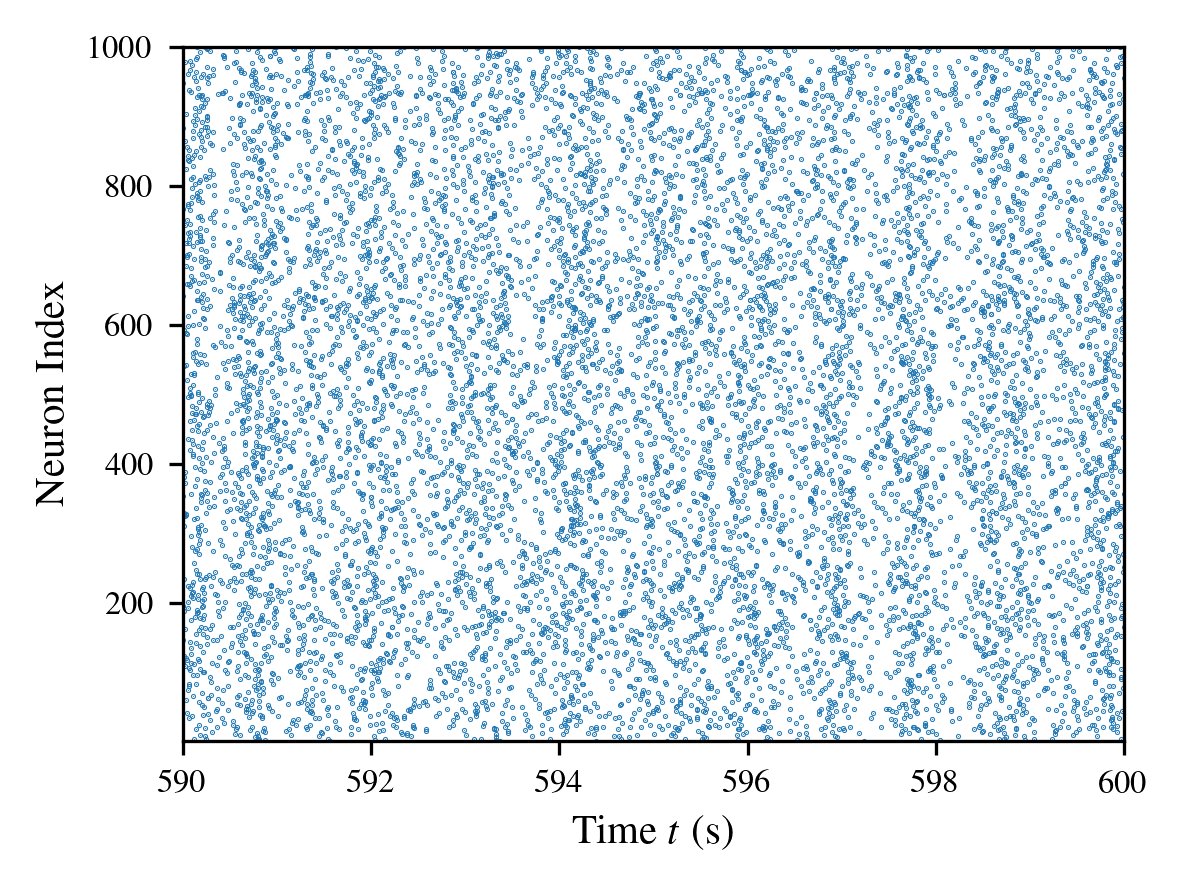

In [294]:
ax = raster_plot(spike_times/1e3, spike_idces, N=N, tmin=tmax-10, tmax=tmax)
ax.set_xlabel('Time $t$ (s)')
ax.set_ylabel('Neuron Index')
None

## Reproduce Some Plots From Schneidman et al.'s 2008 Nature Paper

In [295]:
def make_raster_matrix(times, idces, cells, bin_width):
    """
    Given event times and the cells which produced those events, 
    select the events produced by the given subset of cells and 
    make a boolean matrix of those spike times.
    """
    indices = np.hstack([times[idces == i] // bin_width for i in cells])
    indptr = np.cumsum([0] + [(idces == i).sum() for i in cells])
    return sparse.csr_matrix((np.ones_like(indices), indices, indptr))

def pearson(spikes):
    Exy = (spikes @ spikes.T) / spikes.shape[1]
    Ex = np.array(spikes.mean(axis=1))
    
    # Calculating std is convoluted 
    spikes2 = spikes.copy()
    spikes2.data **= 2
    Ex2 = np.array(spikes2.mean(axis=1))
    σx = np.sqrt(Ex2 - Ex**2)
    
    # Some cells won't fire in the whole observation window.
    # These should be treated as uncorrelated with everything 
    # else, rather than generating infinice Pearson coefficients.
    σx[σx == 0] = np.inf
    
    corr = np.array(Exy - Ex*Ex.T) / (σx*σx.T)
    np.fill_diagonal(corr, 1)
    return corr

In [296]:
spikemat = make_raster_matrix(spike_times, spike_idces, np.arange(N), bin_width=100)

In [297]:
corr = pearson(spikemat)

<IPython.core.display.Javascript object>


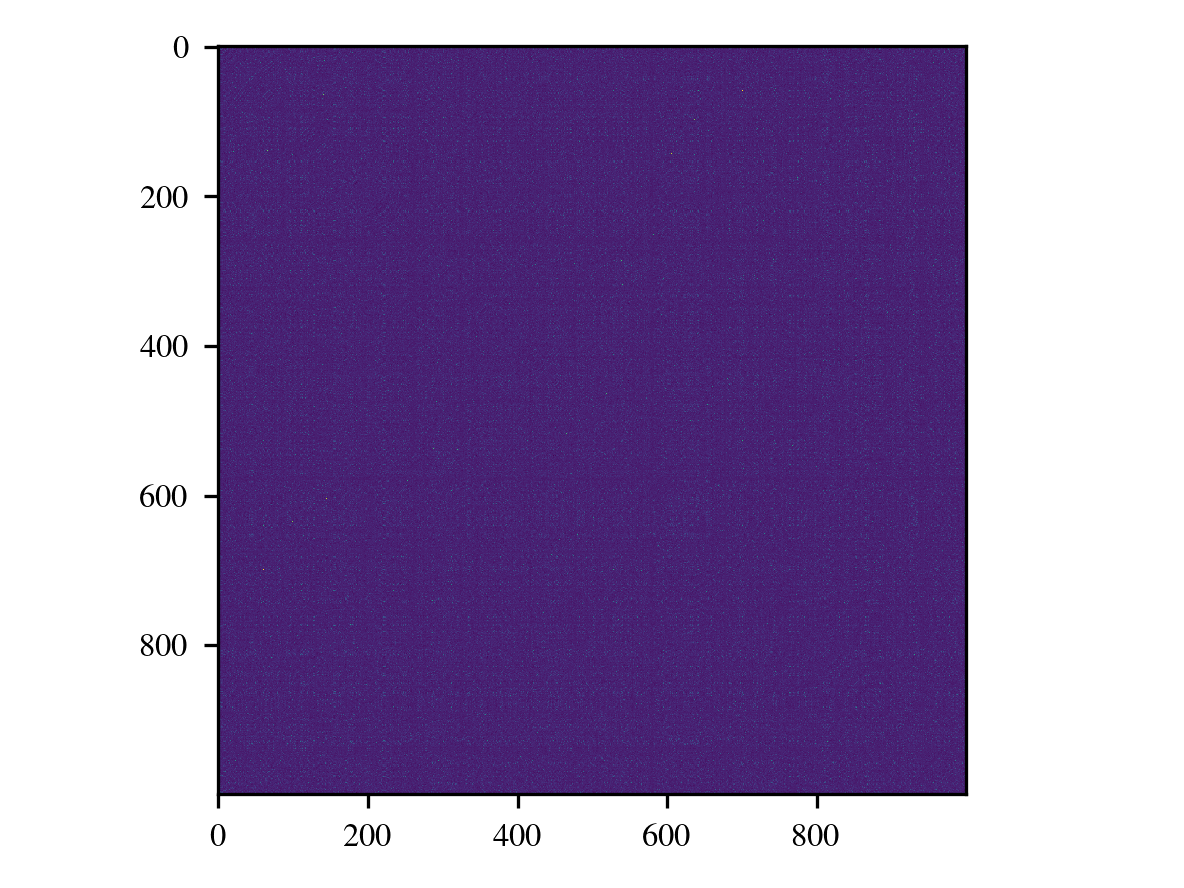

In [298]:
cc = corr - np.eye(N)
cc -= cc.min()
cc /= cc.max()
plt.figure().gca().imshow(cc)

<IPython.core.display.Javascript object>


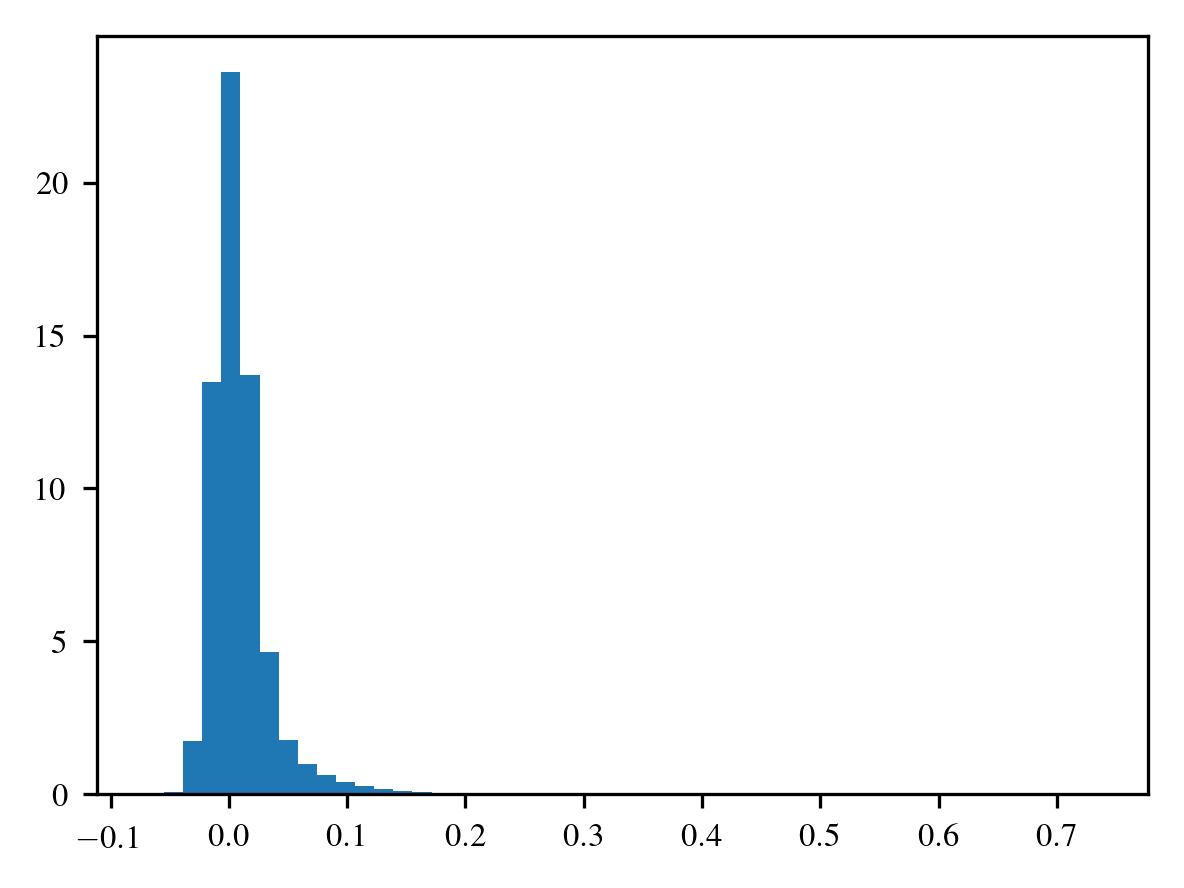

(array([2.72497086e-03, 6.51515759e-02, 1.75079377e+00, 1.34644526e+01,
        2.36251257e+01, 1.37183703e+01, 4.64000605e+00, 1.78993426e+00,
        9.92508703e-01, 6.33555724e-01, 4.03419549e-01, 2.73983433e-01,
        1.75017446e-01, 1.16430573e-01, 7.38219377e-02, 4.79347146e-02,
        2.77451578e-02, 2.19236292e-02, 1.52350643e-02, 9.04194875e-03,
        7.30787638e-03, 3.71586935e-03, 2.22952161e-03, 2.47724623e-03,
        1.61021005e-03, 4.95449246e-04, 2.47724623e-04, 7.43173870e-04,
        6.19311558e-04, 3.71586935e-04, 4.95449246e-04, 1.23862312e-04,
        1.23862312e-04, 1.23862312e-04, 6.19311558e-04, 1.23862312e-04,
        0.00000000e+00, 1.23862312e-04, 1.23862312e-04, 1.23862312e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.23862312e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.23862312e-04]),
 array([-0.07104548, -0.05488236, -0.03871923, -0.02255611, -0.00639298,
         0.00977014, 

In [299]:
cc = corr.flatten()
cc = cc[~np.isclose(cc,1)]
plt.figure().gca().hist(cc, 50, density=True)

In [337]:
x = np.arange(0,1000)
α = 0.1

pdf = N*(1 - np.exp(-α*x))**(N-1) * α*np.exp(-α*x)
cdf = (1 - np.exp(-α*x))**N

In [338]:
(pdf*x).sum()

74.85470860550355

<IPython.core.display.Javascript object>


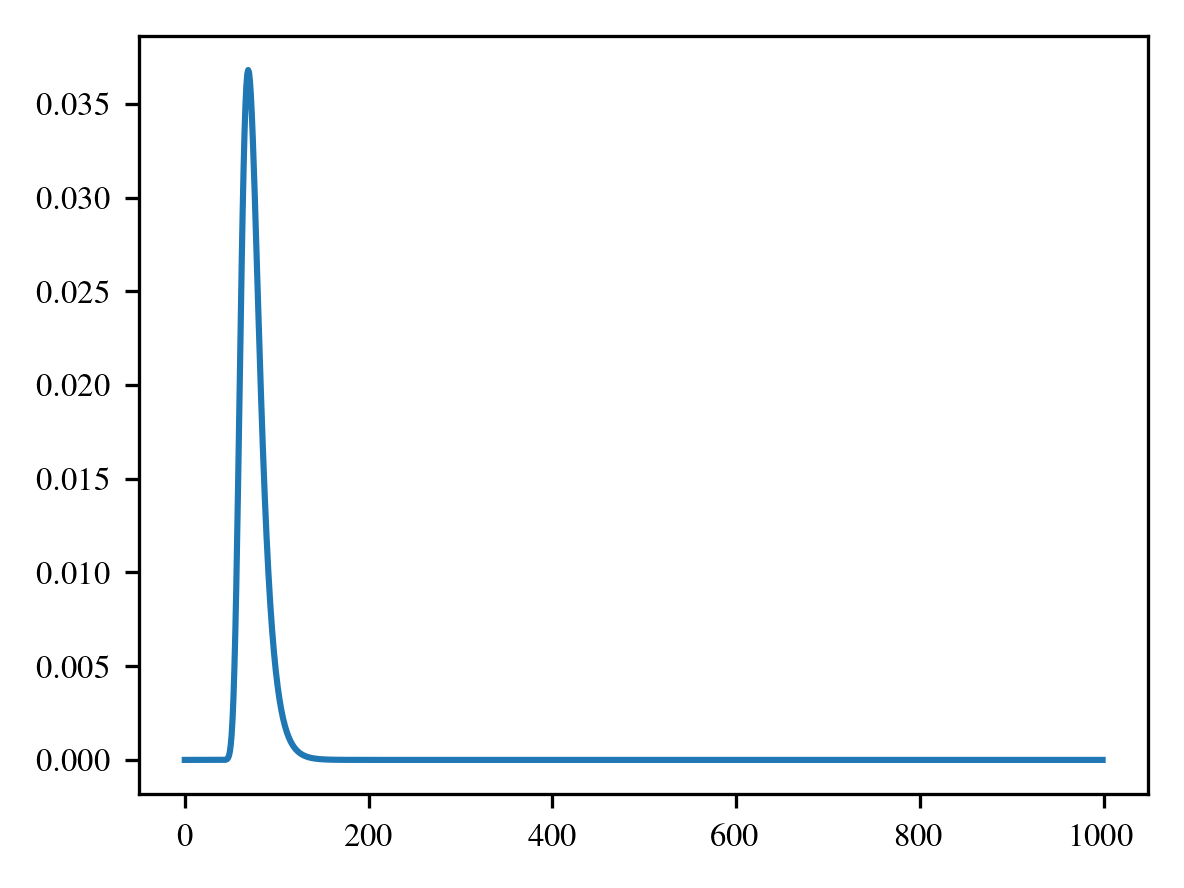

In [340]:
plt.figure().gca().plot(pdf)

## Count the Counts, Find the Threshold

In [300]:
%%time
bin_size = 20
bin_sec = bin_size * 1e-3
rates = analysis.temporal_binning(spike_times, bin_size=bin_size) / bin_sec

CPU times: user 412 ms, sys: 2.43 ms, total: 415 ms
Wall time: 414 ms


In [301]:
thresh = stats.mstats.mquantiles(rates, [0.3])[0]
print(f'Thresholding at {thresh} spikes per s.')

Thresholding at 700.0 spikes per s.


<IPython.core.display.Javascript object>


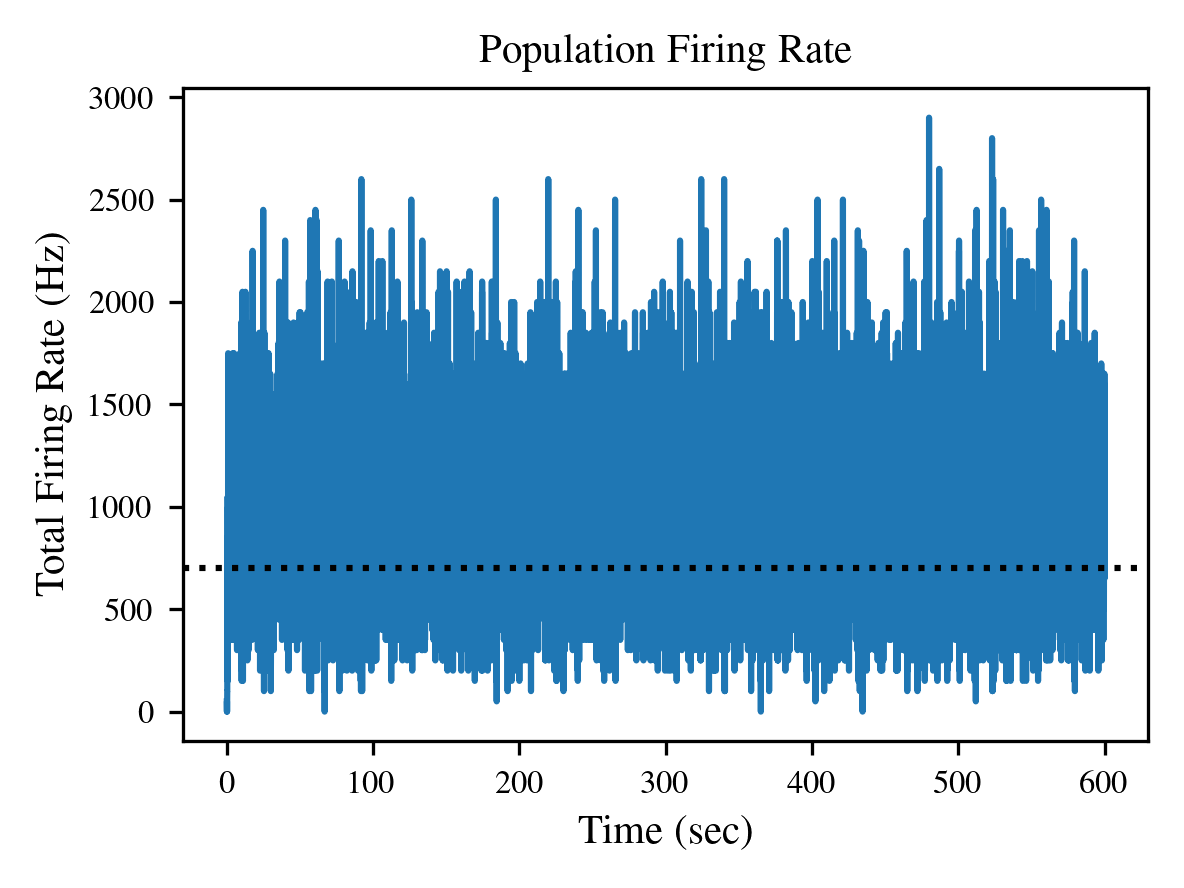

Text(0.5, 1.0, 'Population Firing Rate')

In [302]:
ax = plt.figure().gca()
bin_times = np.arange(len(rates)) * (bin_size / 1e3)
ax.plot(bin_times, rates)
ax.axhline(thresh, linestyle=':', color='k')
ax.set_ylabel('Total Firing Rate (Hz)')
ax.set_xlabel('Time (sec)')
ax.set_title('Population Firing Rate')

In [303]:
avalanches = analysis.get_avalanches(rates*bin_sec, thresh*bin_sec)
sizes = np.array([sum(av) for av in avalanches])
durations = np.array([len(av)*bin_sec for av in avalanches])

print(f'There were {len(avalanches)} avalanches!')
print(f'  Size: {sizes.min()} to {sizes.max()} spikes.')
print(f'  Duration: {durations.min()} to {durations.max()} seconds.')

There were 3810 avalanches!
  Size: 15.0 to 930.0 spikes.
  Duration: 0.02 to 0.92 seconds.


## Fitting Distributions
Try fitting both a power-law and a lognormal distribution to the observed distribution of avalanche sizes and durations (via the maximum likelihood method). Then, we plot the difference between the observed distribution histogram, and the two maximum-likelihood estimated probability distributions. 

In [304]:
pl, ln, ex = stats.pareto, stats.lognorm, stats.expon

size_pl = pl(*pl.fit(sizes, floc=0, fscale=thresh*bin_sec))
size_ex = ex(*ex.fit(sizes, floc=thresh*bin_sec))
size_ln = ln(*ln.fit(sizes, floc=0))

duration_pl = pl(*pl.fit(durations, floc=0, fscale=bin_sec))
duration_ex = ex(*ex.fit(durations, floc=bin_sec))
duration_ln = ln(*ln.fit(durations, floc=0))

/Users/atspaeth/.anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


<IPython.core.display.Javascript object>


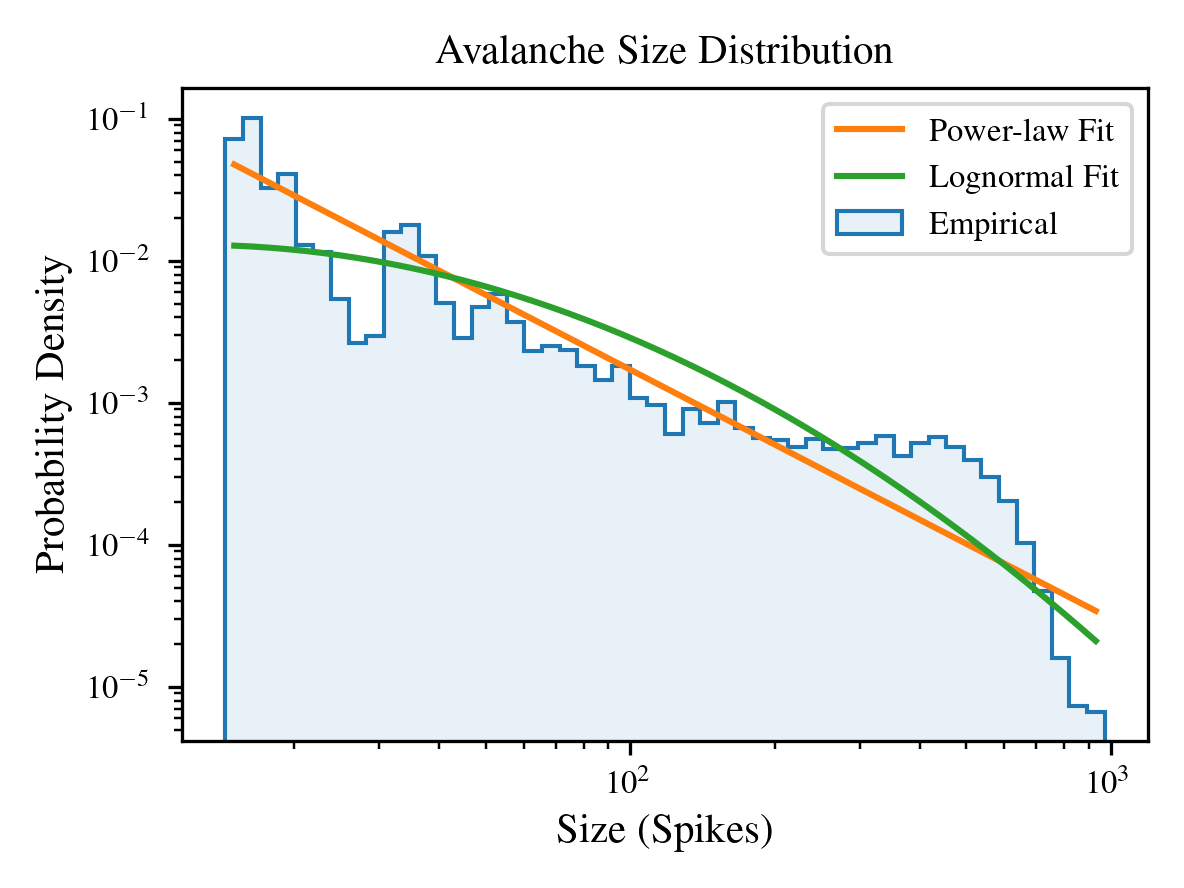

In [305]:
ax = plt.figure().gca()
ax.set_title('Avalanche Size Distribution')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Size (Spikes)')

srange = np.geomspace(sizes.min(), sizes.max())
empirical_pdf(ax, sizes, bins=center_geom_bins(srange), label='Empirical')

ax.loglog(srange, size_pl.pdf(srange), label='Power-law Fit')
ax.plot(srange, size_ln.pdf(srange), label='Lognormal Fit')

# ax.set_ylim(0.75, 1)
ax.legend()

<IPython.core.display.Javascript object>


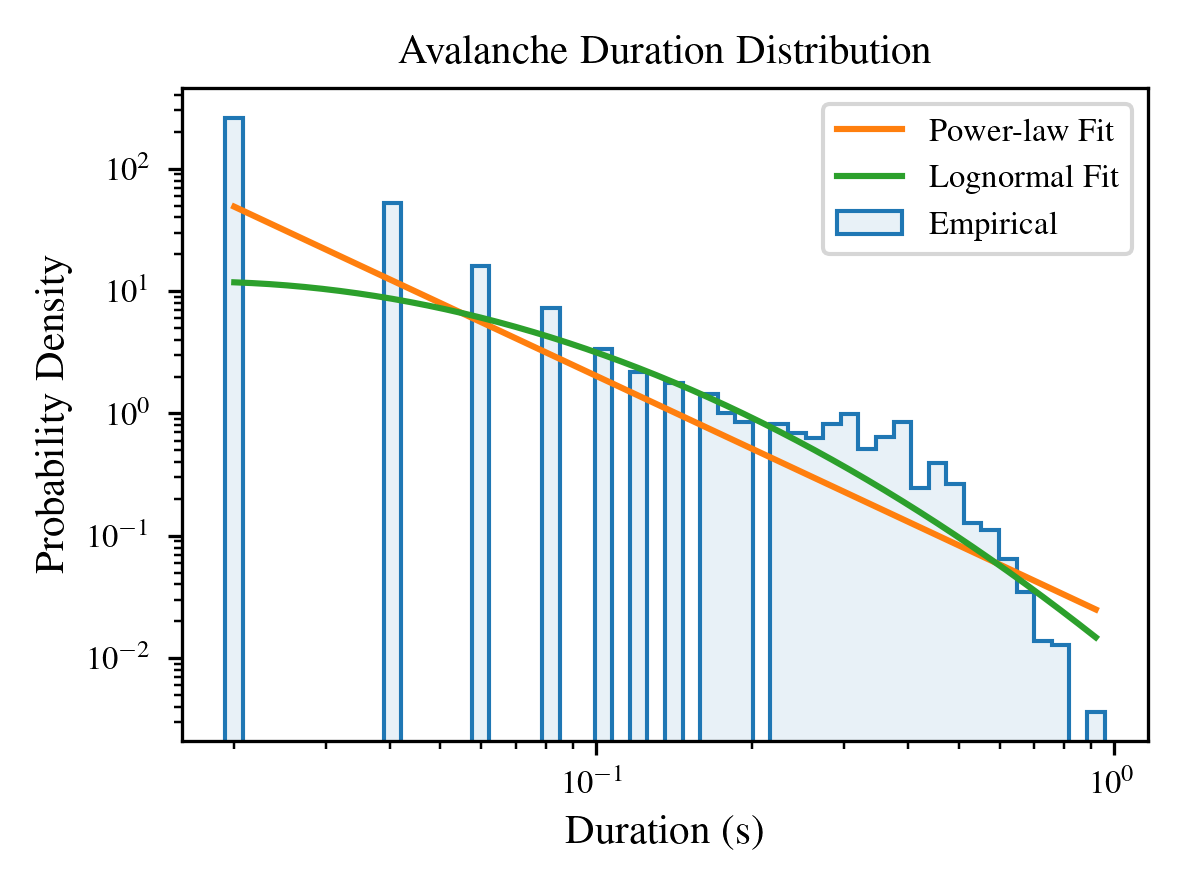

In [306]:
ax = plt.figure().gca()
ax.set_title('Avalanche Duration Distribution')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Duration (s)')

drange = np.geomspace(durations.min(), durations.max())
empirical_pdf(ax, durations, bins=center_geom_bins(drange), label='Empirical')

ax.loglog(drange, duration_pl.pdf(drange), label='Power-law Fit')
ax.plot(drange, duration_ln.pdf(drange), label='Lognormal Fit')

ax.legend()

<IPython.core.display.Javascript object>


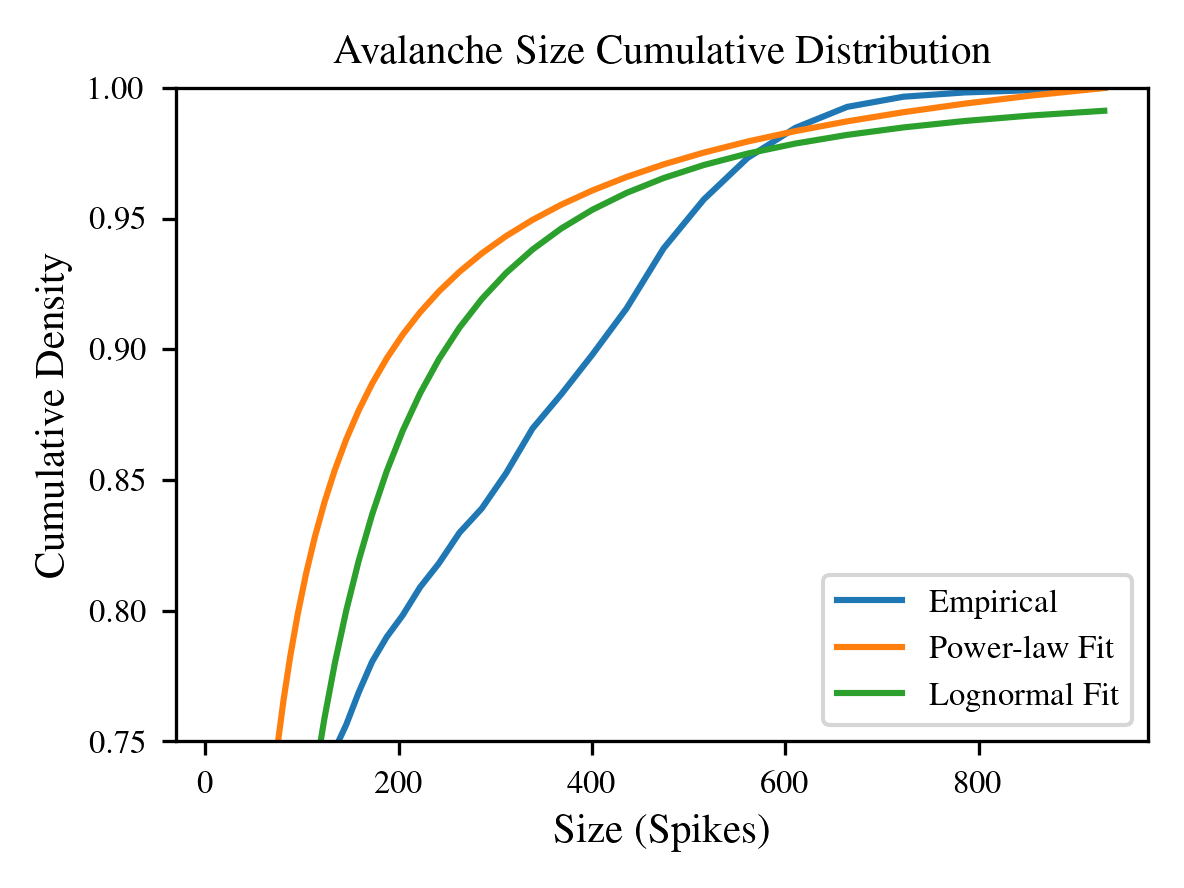

In [307]:
ax = plt.figure().gca()
ax.set_title('Avalanche Size Cumulative Distribution')
ax.set_ylabel('Cumulative Density')
ax.set_xlabel('Size (Spikes)')

srange = np.geomspace(sizes.min(), sizes.max())
cdf = smooth_empirical_cdf(sizes)

ax.plot(srange, cdf(srange), label='Empirical')
ax.plot(srange, truncate_cdf(size_pl.cdf, xmax=sizes.max())(srange), label='Power-law Fit')
ax.plot(srange, size_ln.cdf(srange), label='Lognormal Fit')

ax.set_ylim(0.75, 1)
ax.legend()

<IPython.core.display.Javascript object>


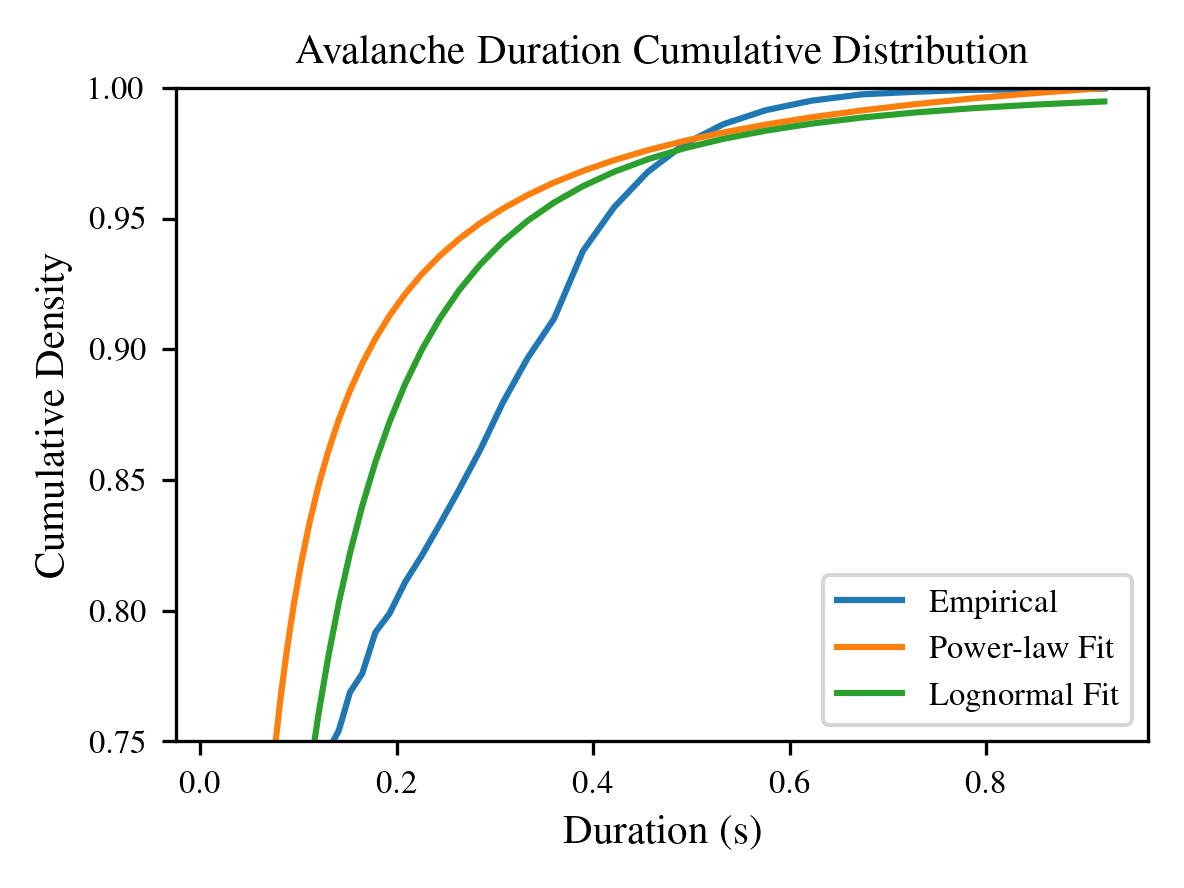

In [308]:
ax = plt.figure().gca()
ax.set_title('Avalanche Duration Cumulative Distribution')
ax.set_ylabel('Cumulative Density')
ax.set_xlabel('Duration (s)')

drange = np.geomspace(durations.min(), durations.max())
cdf = smooth_empirical_cdf(durations)

ax.plot(drange, cdf(drange), label='Empirical')
ax.plot(drange, truncate_cdf(duration_pl.cdf, xmax=durations.max())(drange), label='Power-law Fit')
ax.plot(drange, duration_ln.cdf(drange), label='Lognormal Fit')

ax.set_ylim(0.75, 1)
ax.legend()

## DCC Calculation
If the data _did_ actually seem to follow a power law, this code would calculate the DCC and determine that we are actually at criticality. However, since the data aren't even scale-free in the first place, any calculated DCC value is garbage.

Also note that the relationship between duration and spike count is linear ($m=1$), which means that the average number of spikes per time has no relationship to avalanches. This is another proof that the model is nowhere near critical. I expect this to be closely related to the branching factor. In vertebrates, it seems very conserved at about $m=1.2$, but apparently in zebrafish it was measured at about $m=2$.

In [309]:
scale_fit, m_fit = optimize.curve_fit(lambda x, a,b: a*x**b, durations, sizes)[0]
print(f'Fitted value of m: {m_fit}')

Fitted value of m: 1.0557136829643754


In [310]:
m_pred = duration_pl.args[0] / size_pl.args[0]
print(f'Predicted value of m: {m_pred}')

# Just pick a nice value of the scale factor for display.
scale_pred = optimize.curve_fit(lambda x, a: a*x**m_pred, durations, sizes)[0]

Predicted value of m: 1.3009331259720065


In [311]:
print(f'DCC = {abs(m_pred - m_fit)}')

DCC = 0.2452194430076311


<IPython.core.display.Javascript object>


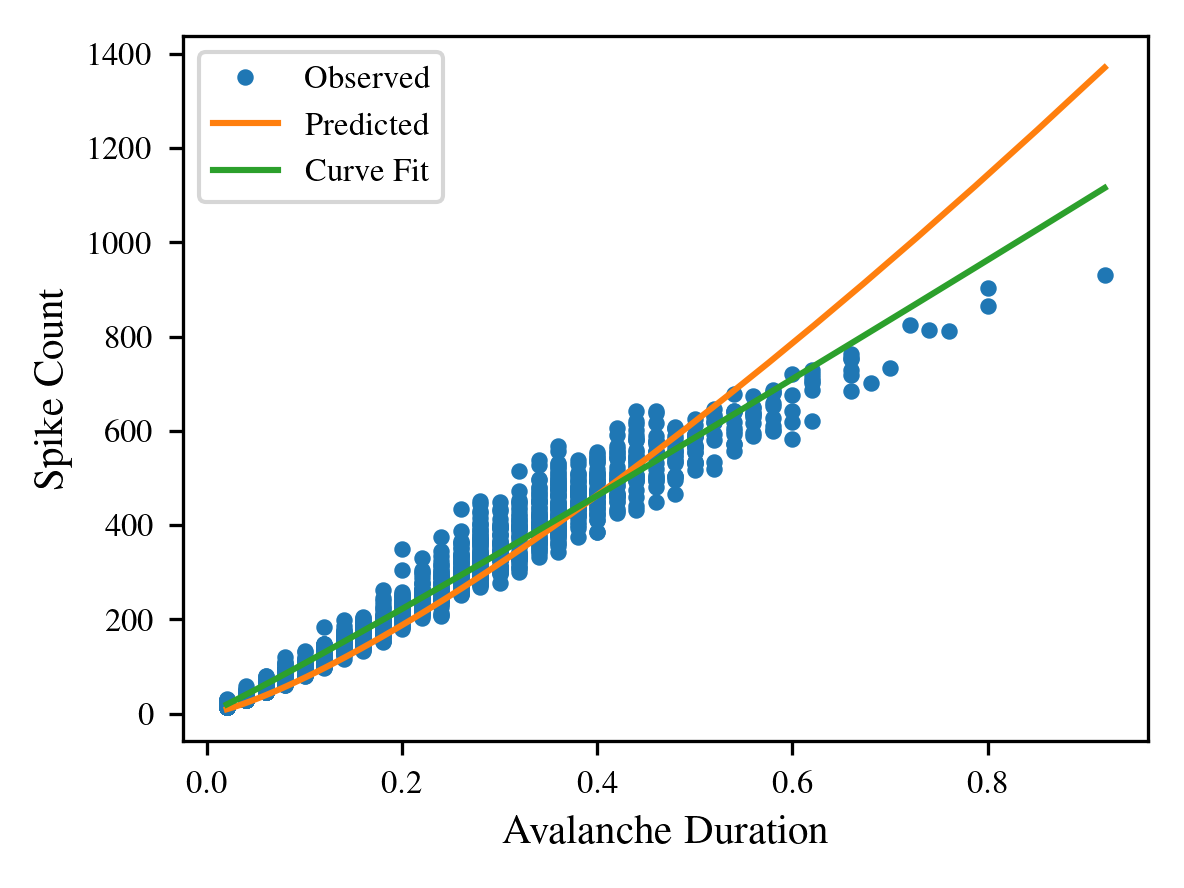

In [312]:
ax = plt.figure().gca()
ax.plot(durations, sizes, '.', label='Observed')
ax.plot(drange, scale_pred*drange**m_pred, label='Predicted')
ax.plot(drange, scale_fit*drange**m_fit, label='Curve Fit')
ax.set_xlabel('Avalanche Duration')
ax.set_ylabel('Spike Count')
ax.legend()

## Shape Collapse

<IPython.core.display.Javascript object>


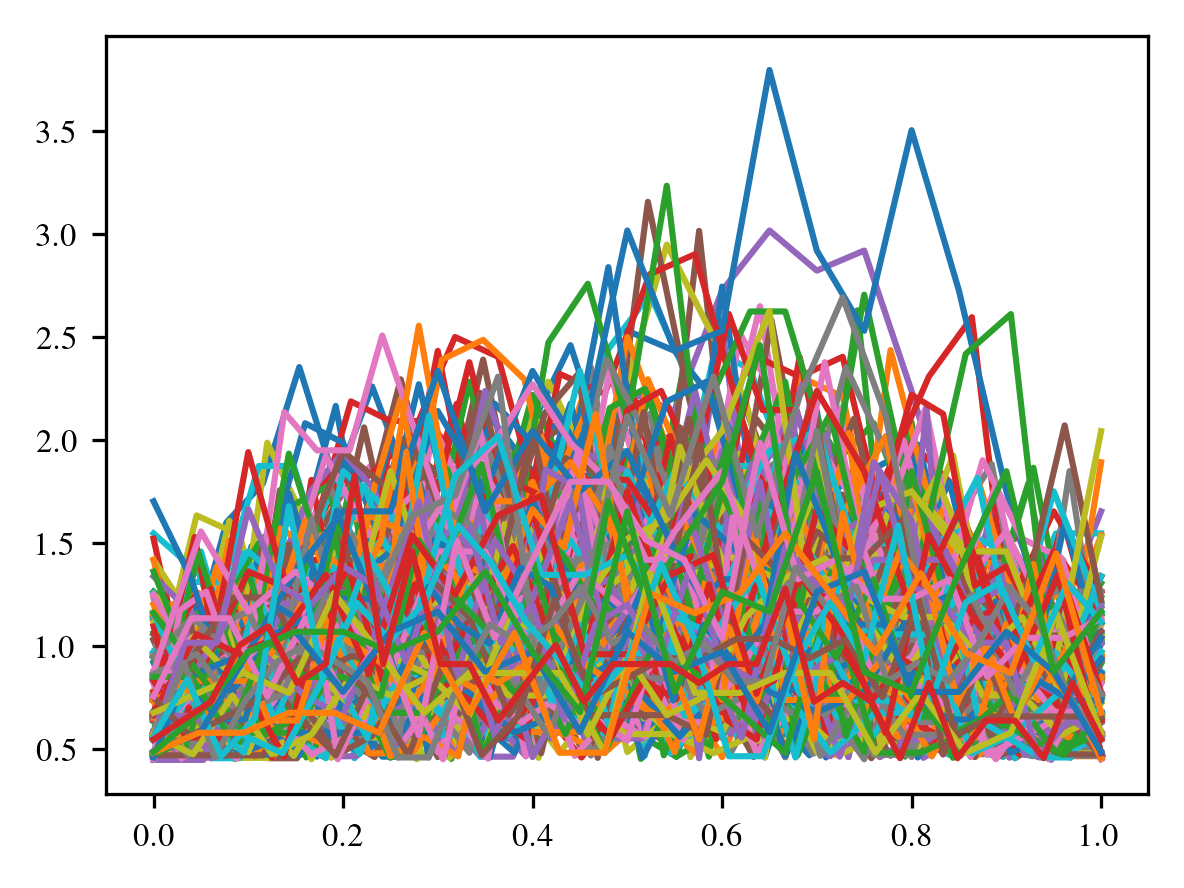

In [57]:
ax = plt.figure().gca()
for avalanche in avalanches:
    
    if not 20 < len(avalanche) < 40: continue
    
    # Normalized time axis.
    t_rescaled = np.linspace(0, 1, len(avalanche))
    
    # Predicted total number of spikes in this avalanche.
    duration = len(avalanche) * bin_size*1e-3
    size_fit = scale_fit * duration**m_fit
    
    # Expected average spikes per bucket.
    spikes_per_bucket = size_fit / len(avalanche)
    
    ax.plot(t_rescaled, np.array(avalanche) / spikes_per_bucket)


# For Fun, A Video

In [56]:
import matplotlib.animation

<IPython.core.display.Javascript object>


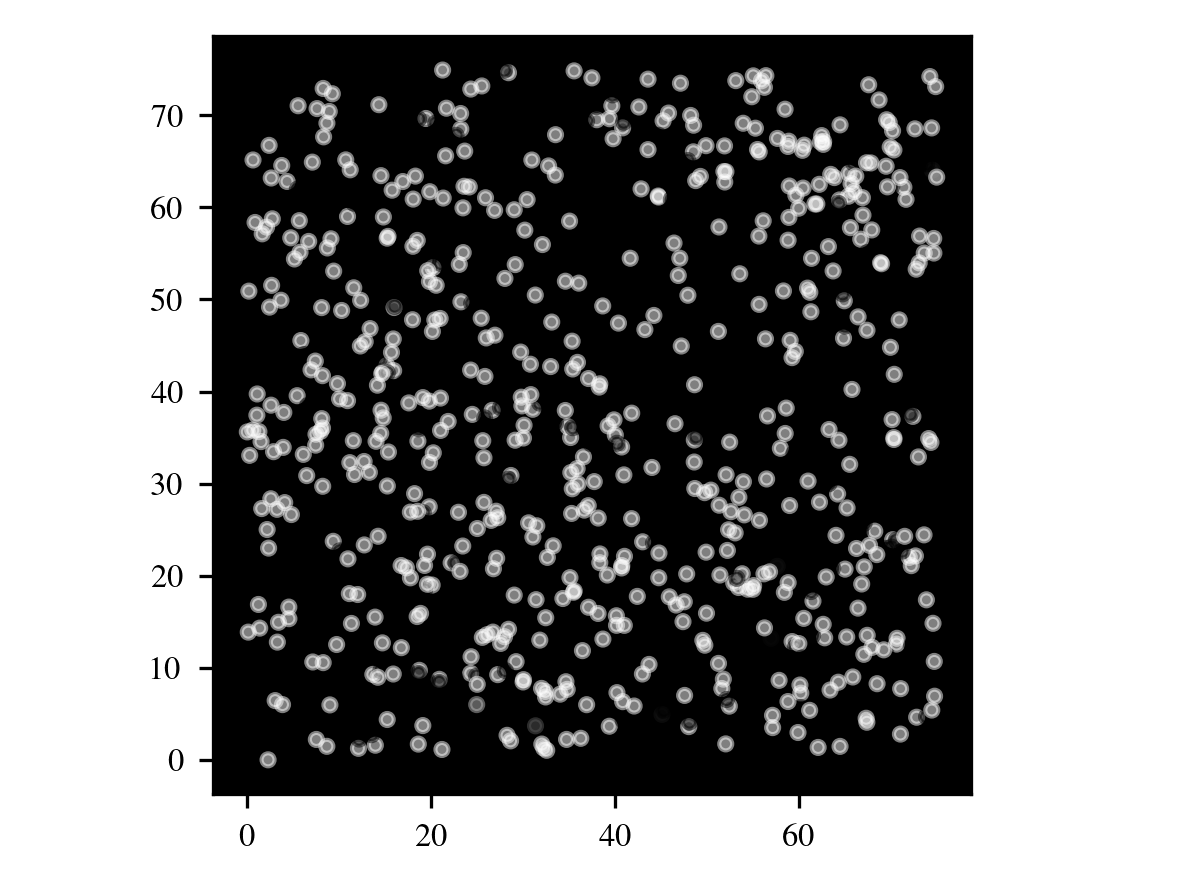

In [58]:
fig = plt.figure()
cam = drylab.Ca2tImage(org.XY, org.C/10, tau=100, reactivity=0.2, fig=fig)
cam.animate(dt, zip(spike_times, spike_idces))